In [1]:
pip install pytorch-fid torchmetrics

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\umara\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [4]:
pip install torch-fidelity torchvision

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\umara\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch_fidelity import calculate_metrics

# ----------------------------
# Config
# ----------------------------
device = torch.device("cpu")
latent_dim = 100
image_size = 64
real_dir = "real"
fake_dir = "fake"
batch_size = 32
num_samples = 500

# ----------------------------
# Residual Block
# ----------------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return F.relu(x + self.block(x))

# ----------------------------
# Self-Attention Block
# ----------------------------
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.key = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.value = nn.Conv2d(in_dim, in_dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, W, H = x.size()
        proj_query = self.query(x).view(B, -1, W * H).permute(0, 2, 1)
        proj_key = self.key(x).view(B, -1, W * H)
        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=-1)
        proj_value = self.value(x).view(B, -1, W * H)
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(B, C, W, H)
        return self.gamma * out + x

# ----------------------------
# Encoder
# ----------------------------
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            ResidualBlock(64),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            SelfAttention(128),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, latent_dim, 8)
        )

    def forward(self, x):
        return self.encoder(x)

# ----------------------------
# Decoder
# ----------------------------
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 8),
            nn.BatchNorm2d(256), nn.ReLU(),
            ResidualBlock(256),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128), nn.ReLU(),
            ResidualBlock(128),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64), nn.ReLU(),
            ResidualBlock(64),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.decoder(z)

# ----------------------------
# Discriminator
# ----------------------------
def snconv(in_c, out_c, k, s, p):
    return nn.utils.spectral_norm(nn.Conv2d(in_c, out_c, k, s, p))

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            snconv(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            snconv(64, 128, 4, 2, 1),
            nn.LeakyReLU(0.2),
            snconv(128, 256, 4, 2, 1),
            nn.LeakyReLU(0.2),
            snconv(256, 1, 8, 1, 0)
        )

    def forward(self, x):
        return self.net(x).view(-1)

# ----------------------------
# Dataset
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = ImageFolder("D:/Researchwork24-25/work7/wood/wood/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# ----------------------------
# Save Images (Real and Fake)
# ----------------------------
def save_real_images(dataloader, save_path=real_dir, count=500):
    os.makedirs(save_path, exist_ok=True)
    idx = 0
    for images, _ in dataloader:
        for img in images:
            save_image((img + 1) / 2, os.path.join(save_path, f"{idx:05}.png"))  # denormalize
            idx += 1
            if idx >= count:
                return

def save_fake_images(encoder, decoder, dataloader, save_path=fake_dir, count=500):
    os.makedirs(save_path, exist_ok=True)
    encoder.eval()
    decoder.eval()
    idx = 0
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            z = encoder(images)
            fakes = decoder(z)
            for fake in fakes:
                save_image((fake + 1) / 2, os.path.join(save_path, f"{idx:05}.png"))  # denormalize
                idx += 1
                if idx >= count:
                    return

# ----------------------------
# Evaluate: FID + Inception Score
# ----------------------------
def evaluate_fid_is(real_path, fake_path):
    metrics = calculate_metrics(
        input1=real_path,
        input2=fake_path,
        cuda=torch.cuda.is_available(),
        fid=True,
        isc=True
    )
    print("FID Score:", metrics["frechet_inception_distance"])
    print("Inception Score:", metrics["inception_score_mean"])

# ----------------------------
# Main
# ----------------------------
E = Encoder().to(device)
G = Decoder().to(device)
D = Discriminator().to(device)

optimizer_G = torch.optim.Adam(list(E.parameters()) + list(G.parameters()), lr=2e-4)
optimizer_D = torch.optim.Adam(D.parameters(), lr=2e-4)
loss_fn = nn.MSELoss()


In [2]:
# (Optional) Train one epoch for testing
for epoch in range(1):
    for real_imgs, _ in train_loader:
        real_imgs = real_imgs.to(device)
        z = E(real_imgs)
        fake_imgs = G(z)

        # Discriminator update
        D_real = D(real_imgs)
        D_fake = D(fake_imgs.detach())
        d_loss = -torch.mean(D_real) + torch.mean(D_fake)
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Generator update
        D_fake = D(fake_imgs)
        g_loss = -torch.mean(D_fake) + loss_fn(fake_imgs, real_imgs)
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

print("Finished 1 Epoch - Saving images and evaluating...")

# Save sample images
save_real_images(train_loader, real_dir, num_samples)
save_fake_images(E, G, train_loader, fake_dir, num_samples)

# Compute metrics
evaluate_fid_is(real_dir, fake_dir)

Finished 1 Epoch - Saving images and evaluating...


Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to C:\Users\umara/.cache\torch\hub\checkpoints\weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:44<00:00, 2.16MB/s]
Extracting features from input1
Looking for samples non-recursivelty in "real" with extensions png,jpg,jpeg
Found 247 samples
c:\Users\umara\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_fidelity\datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)
Processing samples                 

FID Score: 350.3975245869392
Inception Score: 1.9632435254241762


Frechet Inception Distance: 350.3975245869392


In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# --------------------------
# Configuration
# --------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100
image_size = 64

# --------------------------
# Residual Block
# --------------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return F.relu(x + self.block(x))

# --------------------------
# Self-Attention
# --------------------------
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.query = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.key = nn.Conv2d(in_dim, in_dim // 8, 1)
        self.value = nn.Conv2d(in_dim, in_dim, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, W, H = x.size()
        proj_query = self.query(x).view(B, -1, W * H).permute(0, 2, 1)
        proj_key = self.key(x).view(B, -1, W * H)
        energy = torch.bmm(proj_query, proj_key)
        attention = F.softmax(energy, dim=-1)
        proj_value = self.value(x).view(B, -1, W * H)

        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.view(B, C, W, H)
        return self.gamma * out + x

# --------------------------
# Encoder
# --------------------------
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            ResidualBlock(64),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            SelfAttention(128),
            nn.Conv2d(128, 256, 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, latent_dim, 8)
        )

    def forward(self, x):
        return self.encoder(x)

# --------------------------
# Decoder
# --------------------------
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, 8),
            nn.BatchNorm2d(256), nn.ReLU(),
            ResidualBlock(256),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128), nn.ReLU(),
            ResidualBlock(128),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64), nn.ReLU(),
            ResidualBlock(64),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.decoder(z)


In [4]:
# --------------------------
# Grad-CAM Implementation
# --------------------------
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        self.model.zero_grad()
        output = self.model(input_tensor)
        score = output.norm()
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam


In [5]:
# --------------------------
# Grad-CAM Visualization
# --------------------------
def visualize_grad_cam(image_path, cam):
    image = np.array(Image.open(image_path).resize((64, 64))).astype(np.float32) / 255.0
    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [6]:
# --------------------------
# Apply Grad-CAM on a test image
# --------------------------
def apply_gradcam_on_test_image(encoder_model, image_path):
    from torchvision.transforms import Compose, ToTensor, Normalize, Resize
    encoder_model.eval()
    transform = Compose([
        Resize((64, 64)),
        ToTensor(),
        Normalize([0.5]*3, [0.5]*3)
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(next(encoder_model.parameters()).device)

    target_layer = encoder_model.encoder[-3]
    cam_generator = GradCAM(encoder_model, target_layer)
    cam_map = cam_generator.generate(input_tensor)
    visualize_grad_cam(image_path, cam_map)

In [7]:
# --------------------------
# Apply Grad-CAM on a test image
# --------------------------
def apply_gradcam_on_test_image(encoder_model, image_path):
    from torchvision.transforms import Compose, ToTensor, Normalize, Resize
    encoder_model.eval()
    transform = Compose([
        Resize((64, 64)),
        ToTensor(),
        Normalize([0.5]*3, [0.5]*3)
    ])
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(next(encoder_model.parameters()).device)

    target_layer = encoder_model.encoder[-3]
    cam_generator = GradCAM(encoder_model, target_layer)
    cam_map = cam_generator.generate(input_tensor)
    visualize_grad_cam(image_path, cam_map)


In [11]:
# --------------------------
# Training Loop
# --------------------------
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
train_dataset = ImageFolder("D:/Researchwork24-25/work7/wood/wood/train", transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

E = Encoder().to(device)
D = Decoder().to(device)
optimizer = torch.optim.Adam(list(E.parameters()) + list(D.parameters()), lr=2e-4)
criterion = nn.MSELoss()

for epoch in range(10):
    for images, _ in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        z = E(images)
        recon = D(z)
        loss = criterion(recon, images)
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{10}], Loss: {loss.item():.4f}")

# Save the model
torch.save(E.state_dict(), "trained_encoder.pth")

Epoch [1/10], Loss: 0.0668
Epoch [2/10], Loss: 0.0346
Epoch [3/10], Loss: 0.0249
Epoch [4/10], Loss: 0.0207
Epoch [5/10], Loss: 0.0218
Epoch [6/10], Loss: 0.0174
Epoch [7/10], Loss: 0.0169
Epoch [8/10], Loss: 0.0138
Epoch [9/10], Loss: 0.0180
Epoch [10/10], Loss: 0.0140


c:\Users\umara\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


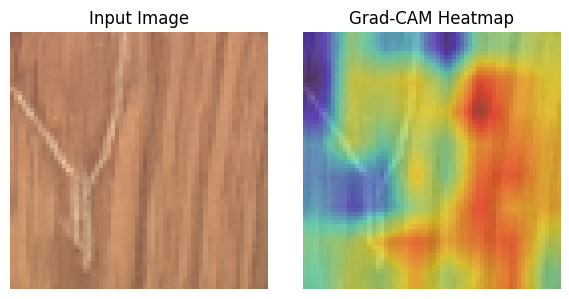

In [13]:
apply_gradcam_on_test_image(E, r"d:\Researchwork24-25\work7\wood\wood\test\scratch\005.png")


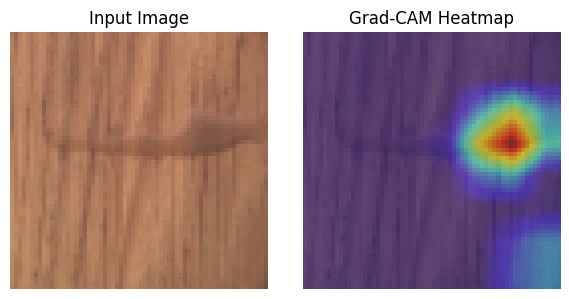

In [14]:
apply_gradcam_on_test_image(E, r"d:\Researchwork24-25\work7\wood\wood\test\liquid\001.png")


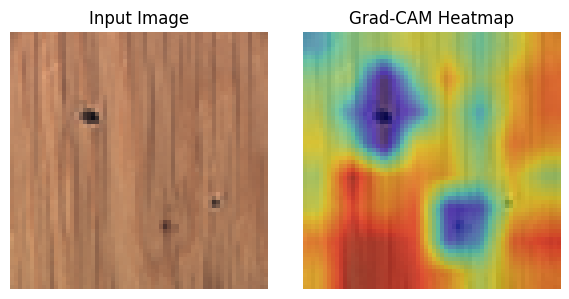

In [15]:
apply_gradcam_on_test_image(E, r"d:\Researchwork24-25\work7\wood\wood\test\hole\000.png")

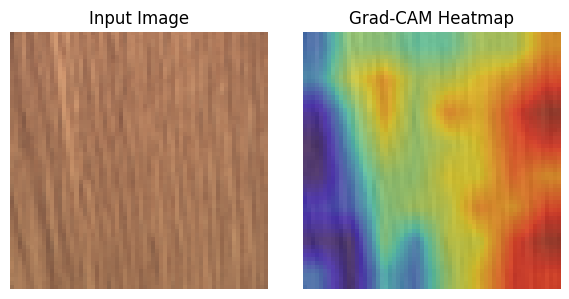

In [16]:
apply_gradcam_on_test_image(E, r"d:\Researchwork24-25\work7\wood\wood\test\good\001.png")